![](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)

[image-source](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)



## Main outline

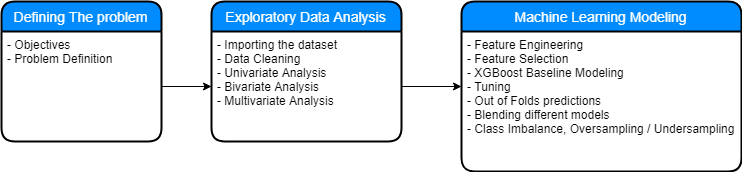

## Exploratory Data Analysis

![](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

[image-source](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

### Importing the dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [ ]:
train.shape, test.shape

In [ ]:
train.columns

At first glance we have many uncharacterized numerical features, their names has the prefix "var_" and they are 200 in numbers. There are so many variables that some histograms will shed light to their numerical appearance.

In [ ]:
train.target.value_counts()

In [ ]:
train['target'].value_counts().plot(kind="pie", figsize=(12,9), colormap="coolwarm")

Here we have a typical imbalanced dataset.

#### check for missing data

In [ ]:
train.isna().sum().sum()

In [ ]:
test.isna().sum().sum()

We have no NA values which is very nice!!

#### Splitting the numerical features

In [ ]:
train.describe()
gc.collect();

In [ ]:
numerical_features = train.columns[2:]

In [ ]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[col]) 
    plt.title(col)
gc.collect();

Almost all features shows a normal distribution shape. Lets see the distributions for for all numerical features per each class.

In [ ]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[train["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train[train["target"] == 1][col], alpha=0.5, label='1', color='r')    
    plt.title(col)
gc.collect();

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].mean().plot('hist');
plt.title('Mean Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].median().plot('hist');
plt.title('Median Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].std().plot('hist');
plt.title('Standard Deviation Frequency');

Most of the distributions show small std. deviations, and very few more than 20. Maybe a log transformation or a scaling technique to all features will alter the graph above to a normal one. 

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].skew().plot('hist');
plt.title('Skewness Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].kurt().plot('hist');
plt.title('Kurtosis Frequency');

Both Skewness and Kurtosis show that the features distributions are like a normal one.

#### correlations between numerical data

In [ ]:
sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            #annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

the figure above shows that most of the pearson correlations between the numerical data are close to zero, in fact is between 0 and 0.2. That means that most of the numerical data are almost uncorrelated between them.

#### Most correlated features:

In [ ]:
s = corr.unstack().drop_duplicates()
so = s.sort_values(kind="quicksort")
so = so.drop_duplicates()

print("Top most highly positive correlated features:")
print(so[(so<1) & (so>0.5)].sort_values(ascending=False))

print()

print("Top most highly megative correlated features:")
print(so[(so < - 0.005)])

### EDA Summary

- We have 200 features that are mostly uncorrelated between them
- 200 numerical features that their histograms have a shape like the one of a normal distribution

## Machine Learning Modeling

![](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)
[image-source](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)

### Feature Engineering

In [ ]:
train.shape, test.shape

In [ ]:
# special thanks to https://www.kaggle.com/gpreda/santander-eda-and-prediction

gc.collect();
for df in [test, train]:
    df['sum'] = df[numerical_features].sum(axis=1)  
    df['min'] = df[numerical_features].min(axis=1)
    df['max'] = df[numerical_features].max(axis=1)
    df['mean'] = df[numerical_features].mean(axis=1)
    df['std'] = df[numerical_features].std(axis=1)
    df['skew'] = df[numerical_features].skew(axis=1)
    df['kurt'] = df[numerical_features].kurtosis(axis=1)
    df['med'] = df[numerical_features].median(axis=1)

In [ ]:
y = train['target']
X = train.drop(['target', "ID_code"], axis=1)

In [ ]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score"])

In [ ]:
def xgboost_all_purpose(X, y, type_of_training, name, num_of_folds=3, params=None, max_early_stopping = 100):
    
    from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
    from collections import Counter
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import time
    import random
    
    import xgboost as xgb
    
    global clf_stats_df
    
    if params is None:
        params = dict()
        params["learning_rate"] = 0.1
        params["n_estimators"] = 500
        params["max_depth"] = 2
        params["min_child_weight"] = 1
        params["gamma"] = 0
        params["subsample"] = 1
        params["colsample_bytree"] = 1
        params["colsample_bylevel"] = 1
        params["reg_alpha"] = 0
        params["reg_lambda"] = 1
        params["scale_pos_weight"] = np.round(y.value_counts()[0] / y.value_counts()[1],3)
        params["max_delta_step"] = 1
    
    print("params", params)
    print("max_early_stopping:", max_early_stopping)
    
    if type_of_training == "baseline":
        
        print("baseline")
        
        # create a 70/30 stratified split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            clf_stra_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    colsample_bylevel=params["colsample_bylevel"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_stra_xgb.predict(xvalid)
            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds
            
            predictions_test += clf_stra_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))
        
        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)
        
        print()
        gc.collect();
        return clf_stra_xgb, predictions_test

    
    elif type_of_training == "oversampling":
        
        print("oversampling")
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        del X_resampled
        del y_resampled
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0        

        start_time = time.time()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
            
            print()
            print("Fold:", num_fold)
            num_fold = num_fold + 1
            print()

            clf_ros_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_ros_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

            predictions = clf_ros_xgb.predict(xvalid)
            predictions_probas = clf_ros_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_ros_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        predictions = np.argmax(predictions_probas, axis=1)
            
        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_ros_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        return clf_ros_xgb, predictions_test
    
    # still needs some work to work
    elif type_of_training == "smote":
        print("smote")
        #### resampling techniques, I will use Synthetic minority:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_smote_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

        clf_smote_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

        predictions = clf_smote_xgb.predict(xvalid)
        predictions_probas = clf_smote_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_smote_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        return clf_smote_xgb
    
    # still needs some work to work
    elif type_of_training == "undersampling":
        print("undersampling")
        #### resampling techniques:
        from imblearn.under_sampling import RandomUnderSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)
        
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_rus_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

        clf_rus_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

        predictions = clf_rus_xgb.predict(xvalid)
        predictions_probas = clf_rus_xgb.predict_proba(xvalid)
        
        
        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_rus_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_rus_xgb
    
    elif type_of_training == "augmentation":
        
        # the main idea here is to reducing the imbalance ratio from 9:1 to 3:1
        print("augmentation")
        
        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

        print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))

        # Augmenting both minority and majority classes via RandomOverSampler by 3 times
        X_y = pd.DataFrame(xtrain, columns=X.columns)
        X_y["target"] = ytrain
        X_y = X_y.sample(frac=3, replace=True)
        X_y.target.value_counts()
        ytrain = X_y['target']
        print("ytrain target values count after oversampling:\n",sorted(Counter(ytrain).items()))
        xtrain = X_y.drop(['target'], axis=1)
        del X_y

        from imblearn.under_sampling import RandomUnderSampler

        # reducing the majority class almost back to its original form
        rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

        print("ytrain target values count after Augmentation:\n",sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        
        del X_resampled
        del y_resampled

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()

            clf_aug_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_aug_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_aug_xgb.predict(xvalid)
            predictions_probas = clf_aug_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_aug_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_aug_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_aug_xgb, predictions_test
    
    else:
        print("Please specify for the argument 'type_of_training'one of the following parameters: (baseline, oversampling, smote, undersampling, augmentation)")

In [ ]:
type_of_training = "oversampling"
num_of_folds = 2 ### must be more than 2
clf_xgb, predictions_test_xgb = xgboost_all_purpose(X,y, num_of_folds = num_of_folds, type_of_training =type_of_training,  max_early_stopping = 100, name="clf_xgb")

#### Test set predictions probabilities histogram

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
plt.hist(predictions_test_xgb)

### Feature Selection - Permutation Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

gc.collect();
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)


rfc_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: np.round(y.value_counts()[0] / y.value_counts()[1],3)}).fit(xtrain, ytrain)

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=42).fit(xvalid, yvalid)

In [ ]:
eli5.show_weights(perm, feature_names = xvalid.columns.tolist(), top=100)

#### Select top 100 features after permutation importance:

In [ ]:
from sklearn.feature_selection import SelectFromModel

max_selected_features = 100
sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)
X_trans = sel.transform(X)

feature_idx = sel.get_support()
selected_feature_names = X.columns[feature_idx]

gc.collect();
X_fs = X[selected_feature_names]
X_fs.shape


### XGBoost Training after Feature Selection

In [ ]:
num_of_folds = 2 ### must be more than 2

fs_clf_xgb, predictions_test_fs_xgb = xgboost_all_purpose(X_fs,y, type_of_training =type_of_training, num_of_folds = num_of_folds, max_early_stopping= 100, name="fs_clf_xgb")

#### Test set prediction probabilities distribution after feature selection

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
plt.hist(predictions_test_fs_xgb)

In [ ]:
clf_stats_df

I believe that Feature selection worsen the auc-score, so I will not use it for the future experiments.

## ML Bayesian Optimization Tuning

In [ ]:
if type_of_training == "baseline":
    
    print("baseline")
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

elif type_of_training == "oversampling":
    
    print("oversampling")
    
    from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

    # create a 70/30 split of the data 
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

    # RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)

    from collections import Counter
    print(sorted(Counter(y_resampled).items()))

    xtrain=pd.DataFrame(X_resampled, columns = X.columns)
    ytrain = y_resampled
    del X_resampled
    del y_resampled

    
elif type_of_training == "augmentation":
    
    # the main idea here is to reducing the imbalance ratio from 9:1 to 3:1
    print("augmentation")
    
    from collections import Counter

    # create a 70/30 split of the data 
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

    print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))

    # Augmenting both minority and majority classes via RandomOverSampler by 3 times
    X_y = pd.DataFrame(xtrain, columns=X.columns)
    X_y["target"] = ytrain
    X_y = X_y.sample(frac=3, replace=True)
    X_y.target.value_counts()
    ytrain = X_y['target']
    print("ytrain target values count after oversampling:\n",sorted(Counter(ytrain).items()))
    xtrain = X_y.drop(['target'], axis=1)
    del X_y

    from imblearn.under_sampling import RandomUnderSampler

    # reducing the majority class almost back to its original form
    rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

    print("ytrain target values count after Augmentation:\n",sorted(Counter(y_resampled).items()))

    xtrain=pd.DataFrame(X_resampled, columns = X.columns)
    ytrain = y_resampled

    del X_resampled
    del y_resampled


In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        nthread = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='auto'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'n_estimators': (50, 100),
        'max_depth': (0, 10),
        'gamma': (1e-4, 20, 'log-uniform'),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-4, 100, 'log-uniform'),
        'reg_alpha': (1e-4, 1.0, 'log-uniform'),
        'max_delta_step': (0, 20),
        'scale_pos_weight': (1e-2, 10, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 1,
    n_iter = 10,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    ### Save all model results
    #clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")
    
# Fit the model
result = bayes_cv_tuner.fit(xtrain, ytrain, callback=status_print)

In [ ]:
result.best_params_['n_estimators'] = 4000

#params['learning_rate'] = 0.01
#params['scale_pos_weight'] = np.round(y.value_counts()[0] / y.value_counts()[1],3)
#params['max_delta_step'] = 1

result.best_params_

### Retraining after tuning

In [ ]:
num_of_folds = 5 ### must be more than 2

tuned_clf_xgb, predictions_test_tuned_xgb = xgboost_all_purpose(X,y, type_of_training = type_of_training, num_of_folds=num_of_folds, params = result.best_params_, max_early_stopping = 400, name="tuned_clf_xgb")

#### Test set predictions probabilities without Feature Selection and with Tuning

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
plt.hist(predictions_test_tuned_xgb)

In [ ]:
clf_stats_df

## ML Blends
** To be updated **

## Preparing for submmission

In [ ]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_xgb
submission.to_csv('clf_xgb.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_fs_xgb
submission.to_csv('fs_clf_xgb.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_tuned_xgb
submission.to_csv('tuned_clf_xgb.csv', index=False)


## Conclusion
We can see from EDA and ML Modeling that class #1 is very unbalanced and difficult to identified and classified.